In [1]:
!nvidia-smi # Run this to see what GPU you have

Fri Apr 18 12:49:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!python --version

Python 3.11.11


INSTALL our guy SHAP

In [3]:
!pip install shap
!pip install pytorch-metric-learning
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_metric_learning import samplers
import csv
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import shap
from sklearn.metrics import f1_score


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device:  cuda


In [5]:
conf = {
    "augmented_root_dir" : "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
    "original_root_dir"  : "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset",
    
    "epoch" : 45, 
    'lr': 0.001,
    'checkpoint_dir': "/kaggle/working",
    'batch_size': 64,
    'num_classes': 4,
}

Verify the shape of some images

In [6]:
plt.imread("/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg").shape

(190, 200, 3)

In [7]:
plt.imread("/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/0033c404-4e68-438d-8312-ba5ba0100d46.jpg").shape

(180, 180, 3)

We should resize all the images to have the same shape

In [8]:
# def load_data(root, images_path_by_class, transform):
#     # iterate through the folders and load the images
#     imgs = []
#     labels = []
#     for i, img_class in tqdm(images_path_by_class, desc="Loading dataset"):
#         images_dir = os.path.join(root, img_class)
#         image_list = os.listdir(images_dir)  # Get all files in the directory
#         for img in image_list:
#             imgs.append()

# inheriet the Pytorch's Dataset class
import random
max_len = 3200

# read the images, and lables, shuffle the array and split it into 3, and return a dictionnary with train, test and val
def read_images_and_spli(root, images_path_by_class):
    img_paths = []
    labels = []

    i = 0  # Class index
    for img_class in tqdm(images_path_by_class, desc="Loading dataset"):
        img_paths_local = []
        labels_local = []
        
        images_dir = os.path.join(root, img_class)
        image_list = os.listdir(images_dir)  # Get all files in the directory
        
        
        for img in image_list:
            img_paths_local.append(os.path.join(images_dir, img))
            labels_local.append(i)  # Assign class index as label
        i += 1

        # while len(img_paths_local) < max_len:
        #     img_paths_local += img_paths_local
        #     labels_local += labels_local

        # Debug print
        # print(f"Number of images in {img_class} = {len(img_paths_local)}, Example: {img_paths_local[-1] if image_list else 'No images'}")
        
        assert len(img_paths) == len(labels), "Images and Labels not same size"

        img_paths += img_paths_local
        labels += labels_local

    # Split the dataset: 70% training, 15% validation, 15% test
    # First, split into 70% training and 30% (which we will further split)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        img_paths, labels, test_size=0.3, random_state=42, stratify=labels)
    
    # Now, split the remaining 30% into 50% for validation and 50% for test (15% each of original data)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

    #oversample training data
    cls0 = []
    cls1 = []
    cls2 = []
    cls3 = []
    for i in range(len(train_paths)):
        if train_labels[i] == 0:
            cls0.append(train_paths[i])
        elif train_labels[i] == 1:
            cls1.append(train_paths[i])
        elif train_labels[i] == 2:
            cls2.append(train_paths[i])
        else:
            cls3.append(train_paths[i])
            
    print(f"After spreadin train lens = {len(cls0)} {len(cls1)} {len(cls2)} {len(cls3)}")

    while len(cls0) < max_len:
        cls0 += cls0
    while len(cls1) < max_len:
        cls1 += cls1
    while len(cls2) < max_len:
        cls2 += cls2
    while len(cls3) < max_len:
        cls3 += cls3

    print(f"After oversampling train lens = {len(cls0)} {len(cls1)} {len(cls2)} {len(cls3)}")
    
    train_paths = cls0 + cls1 + cls2 + cls3
    train_labels = [0] * len(cls0) + [1] * len(cls1) + [2] * len(cls2) + [3] * len(cls3)

    assert len(train_paths) == len(train_labels), "train Images and Labels not same size"

    for i in range(len(train_paths)):
        rn = random.randint(0, len(train_paths) - 1)
        train_paths[i], train_paths[rn] = train_paths[rn], train_paths[i]
        train_labels[i], train_labels[rn] = train_labels[rn], train_labels[i]

    print(f"New train size = {len(train_paths)}")
    
    # Return the datasets
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

    


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path_array, label_array, transform):
        self.transform = transform

        self.img_paths = path_array.copy()
        self.labels = label_array.copy()
                
        assert len(self.img_paths) == len(self.labels), "Images and Labels not same size"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):  #
        image = Image.open(self.img_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label


transformer to resize to 180, 180

In [9]:
def create_transforms(image_size: int = 244, augment = False) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Crop to 224x224
        T.CenterCrop(image_size),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),

        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]


    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
            T.RandomRotation(degrees=(-10, 10))   # Random rotation in range (-10, 10) degrees
            # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors slightly
            # T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translation
        ])

    

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)

gc.collect()

0

In [10]:
# augmented_root_dir = conf["augmented_root_dir"]
original_root_dir = conf["original_root_dir"]

# Transform the image to reshape it to image_size X image_size
image_size = 224
transform = create_transforms(image_size, False)
transform_train = create_transforms(image_size, True)

The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.


In [11]:
images_path_by_class = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
#load the datasets

(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = read_images_and_spli(
                                                                                    original_root_dir,
                                                                                    images_path_by_class
                                                                                )
# augmented_dataset = ImageDataset(augmented_root_dir, images_path_by_class, transform)
# original_dataset = ImageDataset(original_root_dir, images_path_by_class, transform)
train_dataset = ImageDataset(train_paths, train_labels, transform_train)
val_dataset = ImageDataset(val_paths, val_labels, transform)
test_dataset = ImageDataset(test_paths, test_labels, transform)


# Create DataLoaders
batch_size = 32  # You can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 48.91it/s]

After spreadin train lens = 627 45 2240 1568
After oversampling train lens = 5016 5760 4480 6272
New train size = 21528
Train size: 21528, Val size: 960, Test size: 960


Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)


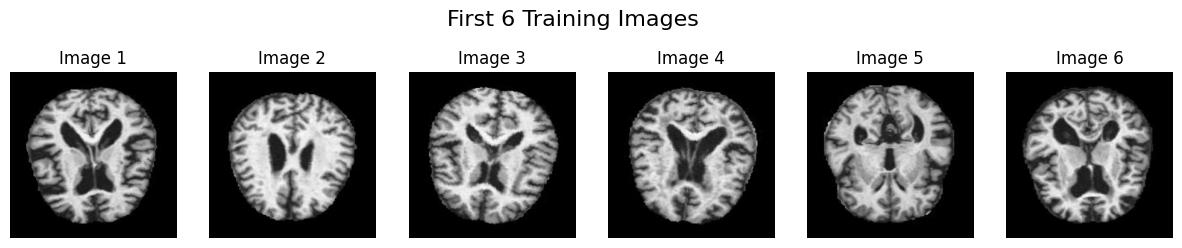

In [12]:
# # display some augmented data:
# image = augmented_dataset.__getitem__(1)[0]
# # Convert tensor (C, H, W) to NumPy (H, W, C) and move values to [0,1]
# image = image.permute(1, 2, 0).numpy() 
# print(f"Shape = {image.shape}")
# image = image * 0.5 + 0.5  # Undo normalization if applied


# plt.imshow(image)
# plt.title("What an augmented image looks like")
# plt.xticks([]); plt.yticks([]);
# plt.show()

num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Create a 1-row grid


for i in range(num_images):
    image, label = train_dataset.__getitem__(i+6)  # Get image and label

    # Convert (C, H, W) tensor to (H, W, C) NumPy array
    image = image.permute(1, 2, 0).numpy()

    # Undo normalization if applied Normalize([0.5], [0.5]) was used)
    image = image * 0.5 + 0.5  
    print(f"Shape = {image.shape}")
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}")  # Title for each image
    axes[i].axis("off")  # Hide axes

plt.suptitle("First 6 Training Images", fontsize=16)  # Set a main title
plt.show()

Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)


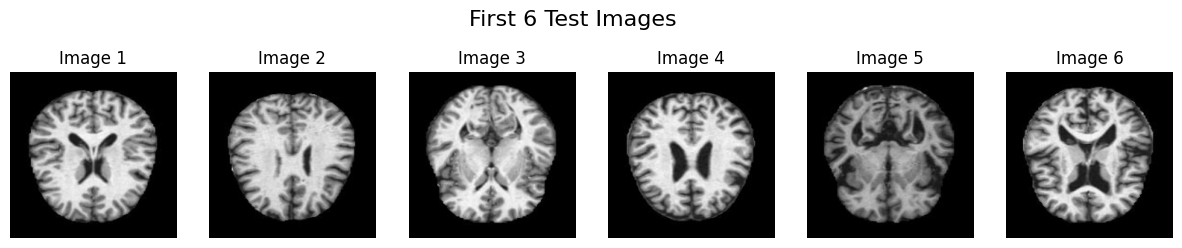

In [13]:
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Create a 1-row grid

for i in range(num_images):
    image, label = test_dataset.__getitem__(i)  # Get image and label

    # Convert (C, H, W) tensor to (H, W, C) NumPy array
    image = image.permute(1, 2, 0).numpy()

    # Undo normalization if applied Normalize([0.5], [0.5]) was used)
    image = image * 0.5 + 0.5  
    print(f"Shape = {image.shape}")
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}")  # Title for each image
    axes[i].axis("off")  # Hide axes

plt.suptitle("First 6 Test Images", fontsize=16)  # Set a main title
plt.show()

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4  # Change expansion to 4 for ResNet-50
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(intermediate_channels)

        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = x + identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.expansion = 4  # Keep expansion factor consistent

        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_layer = nn.Linear(512 * self.expansion, num_classes)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * self.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * self.expansion),
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        out = self.cls_layer(x)

        # return {"feats": x, "out": out}
        return out


# Set up model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(Block, [3, 4, 6, 3], image_channels=3, num_classes=conf['num_classes']).to(DEVICE)

# Print model summary
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=conf['lr'], momentum=0.9, weight_decay=5e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Mixed Precision Training
scaler = torch.amp.GradScaler('cuda')

In [16]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    output_path = "/kaggle/working/confusion_matrix.png"  
    plt.savefig(output_path)
    plt.show()

In [17]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    num_batches = len(loader)

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        # Mixed precision
        with torch.amp.autocast('cuda'):
            # outputs = model(images)["out"]
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backpropagation with mixed precision scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Print progress for each batch
        if i % 10 == 0:  # Print every 10 batches, adjust as needed
            batch_loss = running_loss / (i+1)
            batch_acc = 100 * correct_predictions / total_samples
            print(f"Batch [{i+1}/{num_batches}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%")
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()  # Switch to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    num_batches = len(loader)
    
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient tracking during validation
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and labels for precision, recall, and confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Print progress for each batch
            if i % 10 == 0:  # Print every 10 batches, adjust as needed
                batch_loss = running_loss / (i+1)
                batch_acc = 100 * correct_predictions / total_samples
                print(f"Validation Batch [{i+1}/{num_batches}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%")
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100 * correct_predictions / total_samples

    # Compute precision, recall, and confusion matrix
    precision = precision_score(all_labels, all_preds, average="macro")  # Change to "micro" or "weighted" if needed
    recall = recall_score(all_labels, all_preds, average="macro")
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, conf_matrix

In [18]:
wandb.login(key="99cd4929f90dce17516a1892feca9a9bf05a7df7")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gysoft-sn (gysoft-sn-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [19]:
# Create your wandb run
run = wandb.init(
    name = "run-project-repeat-augm2", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "project-runs", ### Project should be created in your wandb account
    config = conf ### Wandb Config for your run
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250418_125041-he52ytoo
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run run-project-repeat-augm2
wandb: ⭐️ View project at https://wandb.ai/gysoft-sn-carnegie-mellon-university/project-runs
wandb: 🚀 View run at https://wandb.ai/gysoft-sn-carnegie-mellon-university/project-runs/runs/he52ytoo


In [20]:
best_acc = 0.0
for epoch in range(conf["epoch"]):
    print(f"\nEpoch {epoch+1}/{conf['epoch']}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
    val_loss, val_acc, val_precision, val_recall, test_conf_matrix = validate(model, val_loader, criterion, DEVICE)

    print(test_conf_matrix)

    # Log metrics to WandB
    wandb.log({
        "epoch": epoch,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "val/precision": val_precision,
        "val/recall": val_recall
    })

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

    # Save best model based on validation accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(conf['checkpoint_dir'], "best_model.pth"))
        print("New best model saved!")



Epoch 1/45
Batch [1/673], Loss: 1.6354, Acc: 28.12%
Batch [11/673], Loss: 1.4956, Acc: 30.97%
Batch [21/673], Loss: 1.4814, Acc: 29.91%
Batch [31/673], Loss: 1.4834, Acc: 29.23%
Batch [41/673], Loss: 1.4788, Acc: 29.57%
Batch [51/673], Loss: 1.4722, Acc: 28.98%
Batch [61/673], Loss: 1.4577, Acc: 29.35%
Batch [71/673], Loss: 1.4496, Acc: 30.02%
Batch [81/673], Loss: 1.4435, Acc: 30.17%
Batch [91/673], Loss: 1.4312, Acc: 31.01%
Batch [101/673], Loss: 1.4231, Acc: 31.62%
Batch [111/673], Loss: 1.4146, Acc: 32.18%
Batch [121/673], Loss: 1.4024, Acc: 33.45%
Batch [131/673], Loss: 1.3835, Acc: 35.00%
Batch [141/673], Loss: 1.3771, Acc: 35.51%
Batch [151/673], Loss: 1.3626, Acc: 36.26%
Batch [161/673], Loss: 1.3520, Acc: 36.96%
Batch [171/673], Loss: 1.3347, Acc: 37.99%
Batch [181/673], Loss: 1.3175, Acc: 38.97%
Batch [191/673], Loss: 1.3031, Acc: 39.92%
Batch [201/673], Loss: 1.2938, Acc: 40.64%
Batch [211/673], Loss: 1.2852, Acc: 41.29%
Batch [221/673], Loss: 1.2758, Acc: 41.88%
Batch [231

In [21]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [22]:
# # After training, evaluate on the test dataset
# print("\nEvaluating on the test dataset...")
# test_loss, test_acc, test_precision, test_recall, test_conf_matrix = validate(model, test_loader, criterion, DEVICE)

# print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
# print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# print(test_conf_matrix)

# class_names = ["Mild", "Moderate", "No Alzheimer's", "Very Mild"]
# plot_confusion_matrix(test_conf_matrix, class_names)


# print("\nConfusion Matrix:")
# print(test_conf_matrix)
print("\nEvaluating on the test dataset...")
test_loss, test_acc, test_precision, test_recall, test_conf_matrix = validate(model, test_loader, criterion, DEVICE)

# Calculate F1 Score (Macro for balanced class treatment)
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now compute F1
test_f1 = f1_score(all_labels, all_preds, average="macro")  # You can change to "weighted" if needed

print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(test_conf_matrix)



Evaluating on the test dataset...
Validation Batch [1/30], Loss: 0.4633, Acc: 93.75%
Validation Batch [11/30], Loss: 0.3898, Acc: 99.15%
Validation Batch [21/30], Loss: 0.3929, Acc: 98.51%

Test Loss: 0.3957, Test Acc: 98.33%
Test Precision: 0.9887, Test Recall: 0.9846
Test F1 Score: 0.9866
[[131   0   0   4]
 [  0   9   0   0]
 [  1   0 476   3]
 [  0   0   8 328]]


In [23]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ResNet().to(device)
# model.load_state_dict(torch.load("best_model.pth"))  # if saved
# model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
model = ResNet(Block, [3, 4, 6, 3], image_channels=3, num_classes=conf['num_classes']).to(device)

# Load the trained weights
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

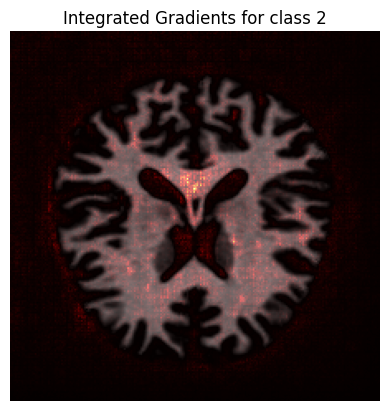

In [24]:
from captum.attr import IntegratedGradients
import torch.nn.functional as F

# Put model in eval mode
model.eval()

# Ensure image has batch dimension and is on device
test_image, test_label = test_dataset[0]
test_image = test_image.unsqueeze(0).to(DEVICE)

# Predict the class
with torch.no_grad():
    output = model(test_image)
    predicted_class = output.argmax(dim=1).item()

from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

# Compute attributions
attributions = ig.attribute(test_image, target=predicted_class, n_steps=10)

import matplotlib.pyplot as plt
import numpy as np

# Convert attribution to numpy
attr = attributions.squeeze().cpu().detach().numpy()
image = test_image.squeeze().cpu().detach().numpy()

# Normalize for visualization
attr = np.abs(attr).mean(0)  # Average across channels

plt.imshow(image.transpose(1, 2, 0))  # Convert CHW -> HWC
plt.imshow(attr, cmap='hot', alpha=0.5)
plt.title(f'Integrated Gradients for class {predicted_class}')
plt.axis('off')
plt.show()

Original image predicted as Class 2


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


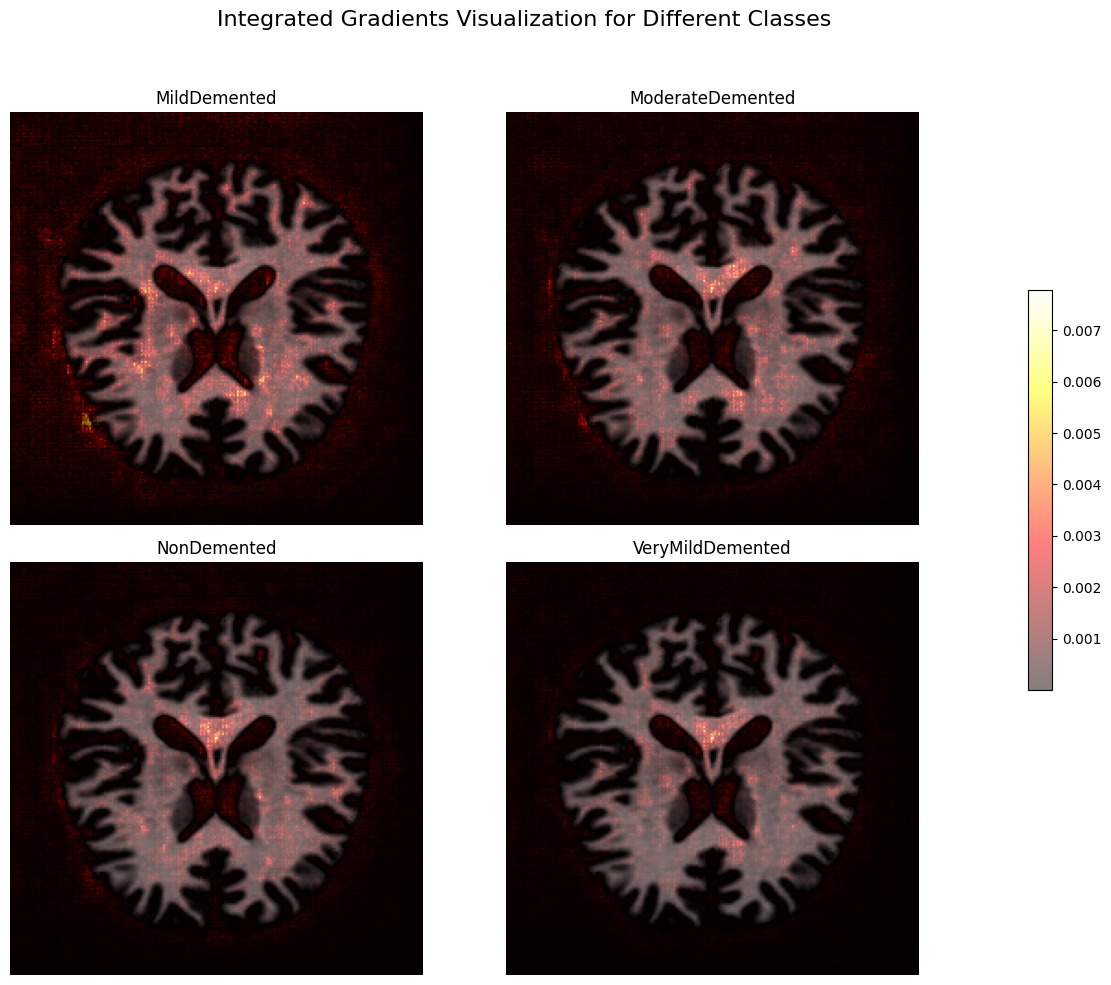

In [25]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt
import numpy as np

# Put model in eval mode
model.eval()

# Create a figure with 4 subplots (2x2 grid for classes 0-3)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Integrated Gradients Visualization for Different Classes', fontsize=16)

# Get a sample image
test_image, test_label = test_dataset[0]
test_image = test_image.unsqueeze(0).to(DEVICE)

# Get the original prediction for reference
with torch.no_grad():
    output = model(test_image)
    predicted_class = output.argmax(dim=1).item()
    
print(f"Original image predicted as Class {predicted_class}")

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Original image for reference (convert CHW -> HWC)
original_img = test_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)

classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Loop through classes 0-3
for class_idx in range(4):
    # Compute attributions for this class
    attributions = ig.attribute(test_image, target=class_idx, n_steps=10)
    
    # Process attributions
    attr = attributions.squeeze().cpu().detach().numpy()
    
    # Normalize for visualization (average across channels)
    attr = np.abs(attr).mean(0)
    
    # Calculate the row and column for the subplot
    row = class_idx // 2
    col = class_idx % 2
    
    # Plot on the corresponding subplot
    ax = axes[row, col]
    
    # Show original image
    ax.imshow(original_img)
    
    # Overlay attributions
    heatmap = ax.imshow(attr, cmap='hot', alpha=0.5)
    
    # Determine class name (replace with actual class names if available)
    class_name = f"Class {class_idx}"
    if class_idx == predicted_class:
        class_name += " (Predicted)"
    
    # Add title
    ax.set_title(f"{classes[class_idx]}")
    ax.axis('off')

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
fig.colorbar(heatmap, cax=cbar_ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

In [26]:
from PIL import Image
import torch
from torchvision import transforms

def predict_image(model, image_path, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the same transformations as during training
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():  # No need to compute gradients for inference
        outputs = model(image)  # Assuming 'out' is the output of the model
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class index

# Define your transform (the same as the training transform without augmentation)
transform_predict = create_transforms(image_size=224, augment=False)

# Provide the path of the image you want to predict
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/28.jpg"

# Call the prediction function
predicted_class = predict_image(model, image_path, transform_predict, DEVICE)

# Print the predicted class index
print(f"Predicted class: {predicted_class}")


Predicted class: 1


The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.


In [27]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms

def predict_image_from_url(model, image_url, transform, device):
    # Download the image from the URL
    response = requests.get(image_url)
    response.raise_for_status()  # Raise an error for bad responses (404, 500, etc.)

    # Open the image
    image = Image.open(BytesIO(response.content)).convert('RGB')

    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(image)  # Assuming 'out' is the output of the model
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class index

# Define your transform (the same as the training transform without augmentation)
transform_predict = create_transforms(image_size=224, augment=False)

# Provide the URL of the image you want to predict
image_url = "https://3acf3052-cdn.agilitycms.cloud/images/service/Brain%20AI%20enhanced.jpg"

# Call the prediction function
predicted_class = predict_image_from_url(model, image_url, transform_predict, DEVICE)

# Print the predicted class index
print(f"Predicted class: {predicted_class}")


Predicted class: 2
